In [1]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
import numpy as np
output_notebook()

Loading BokehJS ...

In [2]:
import zipfile
import lxml.etree
with zipfile.ZipFile(r'D:\C\NLP\Data\ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
content = (doc.xpath('//content/text()'))   # 获取<content>下的文本 数组
keywords = (doc.xpath('//keywords/text()'))  # 获取<keywords[i]s>下的文本 标签
z.close()
del doc

In [3]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

words_list = [word_tokenize(re.sub(r'[^\w\s]', '', str(content[i].lower()))) for i in range(len(content))]
stopwords = stopwords.words('english')
clean_words = []
clean_content = []
for i in range(len(words_list)):
    for word in words_list[i]:
        if word not in stopwords:
            clean_words.append(word)
    clean_content.append(' '.join(clean_words))
    clean_words = []

In [4]:
for i in range(len(keywords)):
    if 'technology' not in keywords[i] and 'entertainment'not in keywords[i] and 'design' not in keywords[i]:
        keywords[i] = 'ooo'
    elif 'technology' in keywords[i] and 'entertainment' not in keywords[i] and 'design' not in keywords[i]:
        keywords[i] = 'Too'
    elif 'technology' not in keywords[i] and 'entertainment' in keywords[i] and 'design' not in keywords[i]:
        keywords[i] = 'oEo'
    elif 'technology' not in keywords[i] and 'entertainment' not in keywords[i] and 'design' in keywords[i]:
        keywords[i] = 'ooD'
    elif 'technology' in keywords[i] and 'entertainment' in keywords[i] and 'design' not in keywords[i]:
        keywords[i] = 'TEo'
    elif 'technology' in keywords[i] and 'entertainment' not in keywords[i] and 'design' in keywords[i]:
        keywords[i] = 'ToD'
    elif 'technology' not in keywords[i] and 'entertainment' in keywords[i] and 'design' in keywords[i]:
        keywords[i] = 'oED'
    else:
        keywords[i] = 'TED'

In [5]:
import pandas as pd
df_data = {'keywords': keywords, 'content': clean_content}
df = pd.DataFrame(df_data)
df['key_id'] = df['keywords'].factorize()[0]
key_id_df = df[['keywords', 'key_id']].drop_duplicates().sort_values('key_id').reset_index(drop=True)
df.sample(10)

,keywords,content,key_id
966,ooo,tonight want conversation incredible global is...,0
1584,Too,time art science stare across gulf mutual inco...,4
318,Too,fiftyfour percent worlds population lives citi...,4
1221,oEo,wanted rock star dreamed thats dreamed accurat...,3
1288,Too,us room today lets start admitting lucky dont ...,4
328,ooo,technology brought us much moon landing intern...,0
927,oEo,non english french mais des fois peut voir par...,3
556,Too,neuroscientist mixed background physics medici...,4
1735,oEo,im going play brief video clip video fifth dec...,3
526,ooo,want moment think playing game monopoly except...,0


In [6]:
from collections import Counter

"""
    做个简单的标签统计
"""

c = Counter(keywords)
d = {'keywords': list(c.keys()), 'counts': list(c.values())}
count_key = pd.DataFrame(d)

colors = [ "salmon", "olive", "darkred", "goldenrod", "skyblue", "orange", "blue", "red"]
source = ColumnDataSource(data=dict(key=count_key['keywords'], counts=count_key['counts'],  colors=colors))

p = figure(x_range=count_key['keywords'], y_range=(0,1128), plot_height=350, title="Fruit Counts",tools="") 
p.vbar(x='key', top='counts', source=source,    # 加载数据另一个方式
       width=0.9, alpha = 0.8,
       fill_color='colors',
       legend="key")
show(p)

In [7]:
del content, words_list,  clean_words, keywords, clean_content, stopwords, df_data
# 释放缓存 不需要可注释

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# 设置最频繁使用的50000个词
MAX_NB_WORDS = 50000
# 每条cut_review最大的长度
MAX_SEQUENCE_LENGTH = 250
# 设置Embeddingceng层的维度
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['content'].values)
word_index = tokenizer.word_index
print('共有 %s 个不相同的词语.' % len(word_index))

X = tokenizer.texts_to_sequences(df['content'].values)
# 填充X,让X的各个列的长度统一
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
# 多类标签的onehot展开
Y = pd.get_dummies(df['key_id']).values
print(X.shape)
print(Y.shape)

Using TensorFlow backend.


共有 64369 个不相同的词语.
(2085, 250)
(2085, 8)


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=250, random_state=1)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=250, random_state=1)

print(X_train.shape, Y_train.shape)
print(X_validation.shape, Y_validation.shape)
print(X_test.shape, Y_test.shape)

(1585, 250) (1585, 8)
(250, 250) (250, 8)
(250, 250) (250, 8)


In [29]:
from keras import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
Total params: 5,081,208
Trainable params: 5,081,208
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
from keras.callbacks import EarlyStopping
epochs = 5
batch_size = 64

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
#                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,  validation_data=(X_validation, Y_validation),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 1585 samples, validate on 250 samples
Epoch 1/5
1585/1585 [==============================] - 9s 5ms/step - loss: 1.7488 - accuracy: 0.5243 - val_loss: 1.4276 - val_accuracy: 0.5560
Epoch 2/5
1585/1585 [==============================] - 8s 5ms/step - loss: 1.4220 - accuracy: 0.5407 - val_loss: 1.3796 - val_accuracy: 0.5560
Epoch 3/5
1585/1585 [==============================] - 8s 5ms/step - loss: 1.3625 - accuracy: 0.5407 - val_loss: 1.3483 - val_accuracy: 0.5560
Epoch 4/5
1585/1585 [==============================] - 8s 5ms/step - loss: 1.1749 - accuracy: 0.5584 - val_loss: 1.3605 - val_accuracy: 0.5560
Epoch 5/5
1585/1585 [==============================] - 8s 5ms/step - loss: 0.9624 - accuracy: 0.6353 - val_loss: 1.4562 - val_accuracy: 0.5320


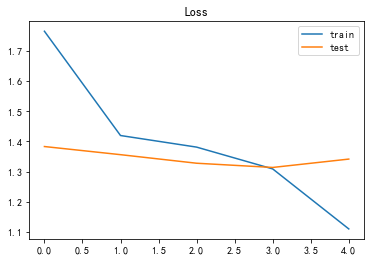

In [13]:
from matplotlib import pyplot as plt  
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

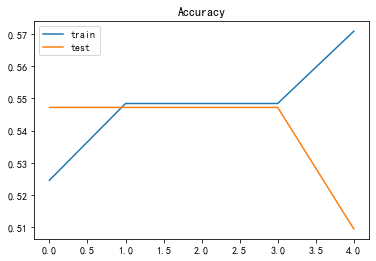

In [14]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Text(0.5, 53.0, '预测结果')

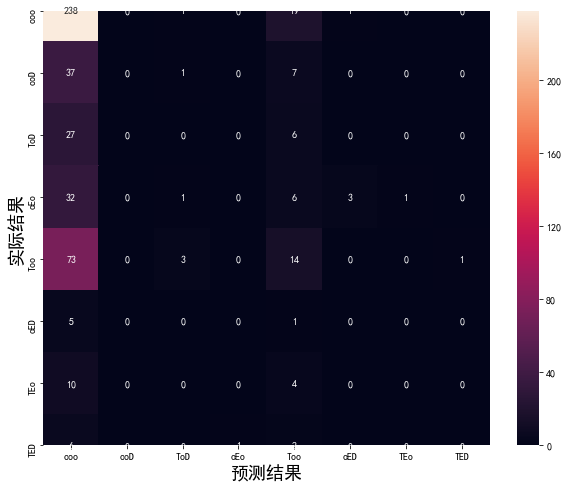

In [15]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
 
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis = 1)
Y_test = Y_test.argmax(axis = 1)
 
#生成混淆矩阵
conf_mat = confusion_matrix(Y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=key_id_df.keywords.values, yticklabels=key_id_df.keywords.values)
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)

In [16]:
from  sklearn.metrics import classification_report
 
print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred,target_names=key_id_df['keywords'].values))

accuracy 0.504
              precision    recall  f1-score   support

         ooo       0.56      0.92      0.69       259
         ooD       0.00      0.00      0.00        45
         ToD       0.00      0.00      0.00        33
         oEo       0.00      0.00      0.00        43
         Too       0.24      0.15      0.19        91
         oED       0.00      0.00      0.00         6
         TEo       0.00      0.00      0.00        14
         TED       0.00      0.00      0.00         9

    accuracy                           0.50       500
   macro avg       0.10      0.13      0.11       500
weighted avg       0.33      0.50      0.39       500



D:\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
from nltk.corpus import stopwords
def predict(text):
    txt = re.sub(r'[^\w\s]', '', text.lower())
    txt = [" ".join([w for w in word_tokenize(txt) if w not in  stopwords.words('english')])]
    seq = tokenizer.texts_to_sequences(txt)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    key_id= pred.argmax(axis=1)[0]
    return key_id_df[key_id_df.key_id==key_id]['keywords'].values[0]

In [26]:
predict("So far we've been looking to this new piece of mechanical technology or that great next generation robot as part of a lineup to ensure our species safe passage in space. Wonderful as they are, I believe the time has come for us to complement these bulky electronic giants with what nature has already invented: the microbe, a single-celled organism that is itself a self-generating, self-replenishing, living machine.")

'Too'

In [27]:
predict(' It requires fairly little to maintain, offers much flexibility in design and only asks to be carried in a single plastic tube.')

'ooo'